# Set Up

1. We set ```%load_ext autoreload``` and ```%autoreload 2``` to reload modules instantly when changes had been made in these modules.
2. We use the Intel(R) Extension for Scikit-learn.
3. We identify the ```root``` directory with ```pathlib.Path().resolve()```. In case the Jupyter Notebook is connected with a remote Jupyter server, we look for the directory ```t.ex-Graph``` in ```root```. **NOTE:** Therefore, you have to clone the ```t.ex-Graph``` repository to the home directory of the user, who runs the remote Jupyter notebook. Alternatively, you can simply configure ```root``` yourself.
4. We import the modules contained in ```lib/``` to hide most of the boilerplate code.

In [344]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [345]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [346]:
from os.path import expanduser, join
import pathlib

root = pathlib.Path().resolve()

In [347]:
from os import listdir

dir = listdir(root)
if 't.ex-Graph' in dir:
  root = join(root, 't.ex-Graph')

In [348]:
import sys
sys.path.insert(1, join(root, 'lib'))

import config
import data
import model
import export

# Data Analysis

In [349]:
datasets = [

  {
    'label': 'Chrome 2022',
    'data': data.read(join(root, 'data', 't-ex-graph-chrome-2022.csv')),
    'smote': True
  },

  {
    'label': 'Firefox 2022',
    'data': data.read(join(root, 'data', 't-ex-graph-firefox-2022.csv')),
    'smote': True
  },

  {
    'label': 'Brave 2022',
    'data': data.read(join(root, 'data', 't-ex-graph-brave-2022.csv')),
    'smote': True
  },

  {
    'label': 'Chrome 2023',
    'data': data.read(join(root, 'data', 't-ex-graph-chrome-2023.csv')),
    'smote': True
  }

]

In [350]:
import pandas as pd

from export import mkdir_p
from os.path import join

sparsity = pd.DataFrame(
  columns=['Density'],
  index=[ dataset['label'] for dataset in datasets ]
)

for index, dataset in enumerate(datasets):
  df = dataset['data']
  df = df.drop('id', axis=1)
  df = df.drop('hostsld', axis=1)
  df = df.astype(pd.SparseDtype('float', 0.0))

  sparsity.at[dataset['label'], 'Density'] = '{:0.2f}'.format(df.sparse.density)

dir = join(root, config.results_dir)
mkdir_p(dir)
sparsity.to_csv(join(dir, 'dataset-sparsities.csv'), sep=",")

sparsity

,Density
Chrome 2022,0.39
Firefox 2022,0.38
Brave 2022,0.33
Chrome 2023,0.38


In [351]:
for dataset in datasets:
  data.binary_classification_labels(
    config.binary_tracker, 
    dataset.get('data'),
    lambda x : x >= 0.5
  )

## Imbalanced Tracker Distribution

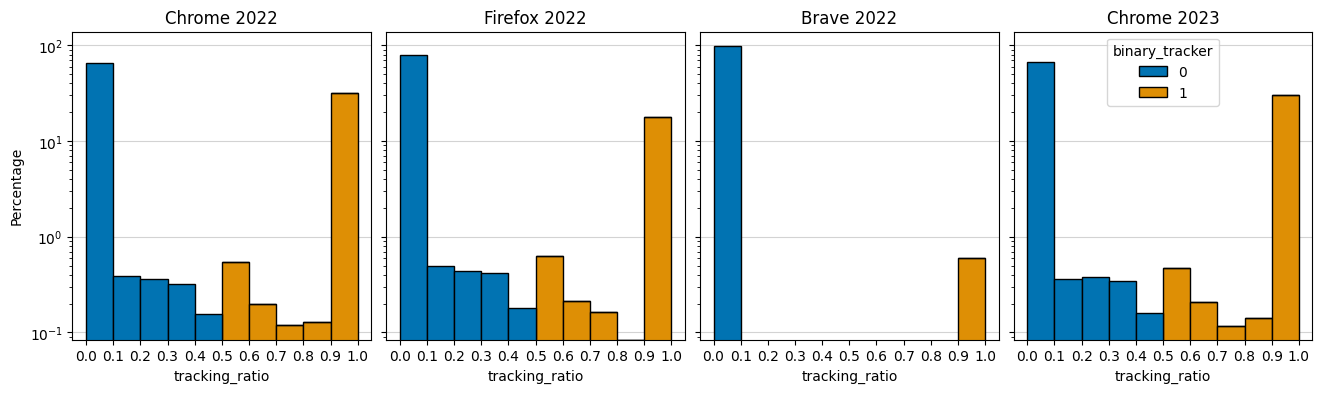

In [352]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from export import mkdir_p
from os.path import join

n = len(datasets)
alpha = 4

fig, axes = plt.subplots(ncols=n, figsize=(n *alpha, alpha), sharey=True)

for index, dataset in enumerate(datasets):
  x = dataset['data']['tracking']
  
  if n == 1:
    ax = axes
  else:
    ax = axes[index]

  ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))

  sns.histplot(
    data=dataset['data'], 
    x='tracking',
    hue=config.binary_tracker,
    ax=ax,
    binwidth=0.1,
    stat='percent',
    palette='colorblind',
    legend=True if index == n-1 else False,
    multiple='stack',
    alpha=1
  ).set(
    title=dataset['label'], 
    xlabel='tracking_ratio',
    ylabel='Percentage',
    yscale='log'
  )

  ax.set_axisbelow(True)
  ax.grid(color='lightgray', axis='y')

fig.subplots_adjust(hspace=0.125, wspace=0.05)

dir = join(root, config.results_dir)
mkdir_p(dir)
plt.savefig(join(dir, 'imbalanced-tracker-distribution.pdf'), dpi=300, bbox_inches='tight')

## Bimodal Distribution

In [353]:
import pandas as pd

def o(n):
  return '{:0.2f}'.format(n)

rows = list()

for dataset in datasets:
  df = dataset['data']
  total = len(df)

  rows.append([
    o((len(df[df['tracking'] == 0]) / total) * 100), 
    o((len(df[(1 > df['tracking']) & (df['tracking'] > 0)]) / total) * 100), 
    o((len(df[df['tracking'] == 1]) / total) * 100),
    o((len(df[df[config.binary_tracker] == 0]) / total) * 100),
    o((len(df[df[config.binary_tracker] == 1]) / total) * 100),
  ])

result = pd.DataFrame(
  rows, 
  columns=[
    'tracking_ratio = 0',
    '1 > tracking_ratio > 0',
    'tracking_ratio = 1',
    config.binary_tracker + ' = 0',
    config.binary_tracker + ' = 1',
  ],
  index=[ dataset['label'] for dataset in datasets ]
)

dir = join(root, config.results_dir)
mkdir_p(dir)
result.to_csv(join(dir, 'tracking-ratio-and-label-distribution.csv'), sep=",")
result

,tracking_ratio = 0,1 > tracking_ratio > 0,tracking_ratio = 1,binary_tracker = 0,binary_tracker = 1
Chrome 2022,65.04,3.32,31.64,67.18,32.82
Firefox 2022,78.74,3.60,17.66,81.14,18.86
Brave 2022,99.15,0.25,0.60,99.31,0.69
Chrome 2023,66.75,3.25,30.01,68.86,31.14


## In-degree Distribution

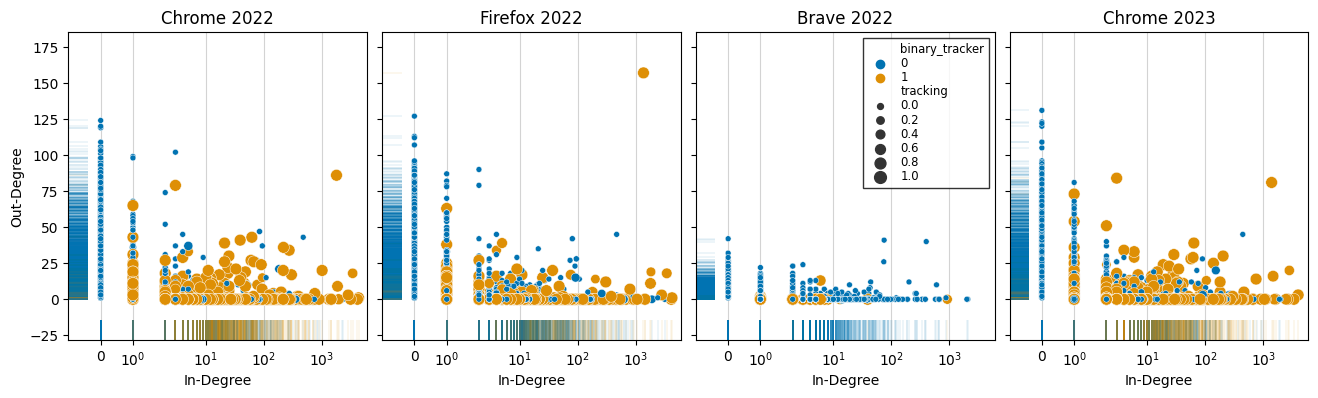

In [354]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.seterr(divide='ignore')

from export import mkdir_p
from os.path import join

n = len(datasets)
alpha = 4

fig, axes = plt.subplots(ncols=n, figsize=(n * alpha, n), sharey=True, sharex=True)

for index, dataset in enumerate(datasets):
  df = dataset['data']#.sample(n=100)

  if n == 1:
    ax = axes
  else:
    ax = axes[index]

  ax.set_xlim(-1, 6000)

  sns.rugplot(
    data=df, 
    x='indegree',
    y='outdegree',
    hue=config.binary_tracker,
    ax=ax,
    palette='colorblind',
    lw=0.1,
    legend=False,
    clip_on=True,
    height=0.065
  ).set(
    xscale='symlog'
  )

  sns.scatterplot(
    data=df, 
    x='indegree',
    y='outdegree',
    size='tracking',
    hue=config.binary_tracker,
    ax=ax,
    palette='colorblind',
    legend= 'brief' if index == n-2 else False,
  ).set(
    title=dataset['label'], 
    xlabel='In-Degree',
    ylabel='Out-Degree',
    xscale='symlog'
  )

  ax.set_axisbelow(True)
  ax.grid(color='lightgray', axis='x')

  if index == n-2:
    ax.legend(loc='upper right', edgecolor='black', fancybox=False, labelspacing=0.1, fontsize='small')

fig.subplots_adjust(hspace=0.125, wspace=0.05)

dir = join(root, config.results_dir)
mkdir_p(dir)
plt.savefig(join(dir, 'indegree-distribution.pdf'), dpi=300, bbox_inches='tight')

## HITSCentrality

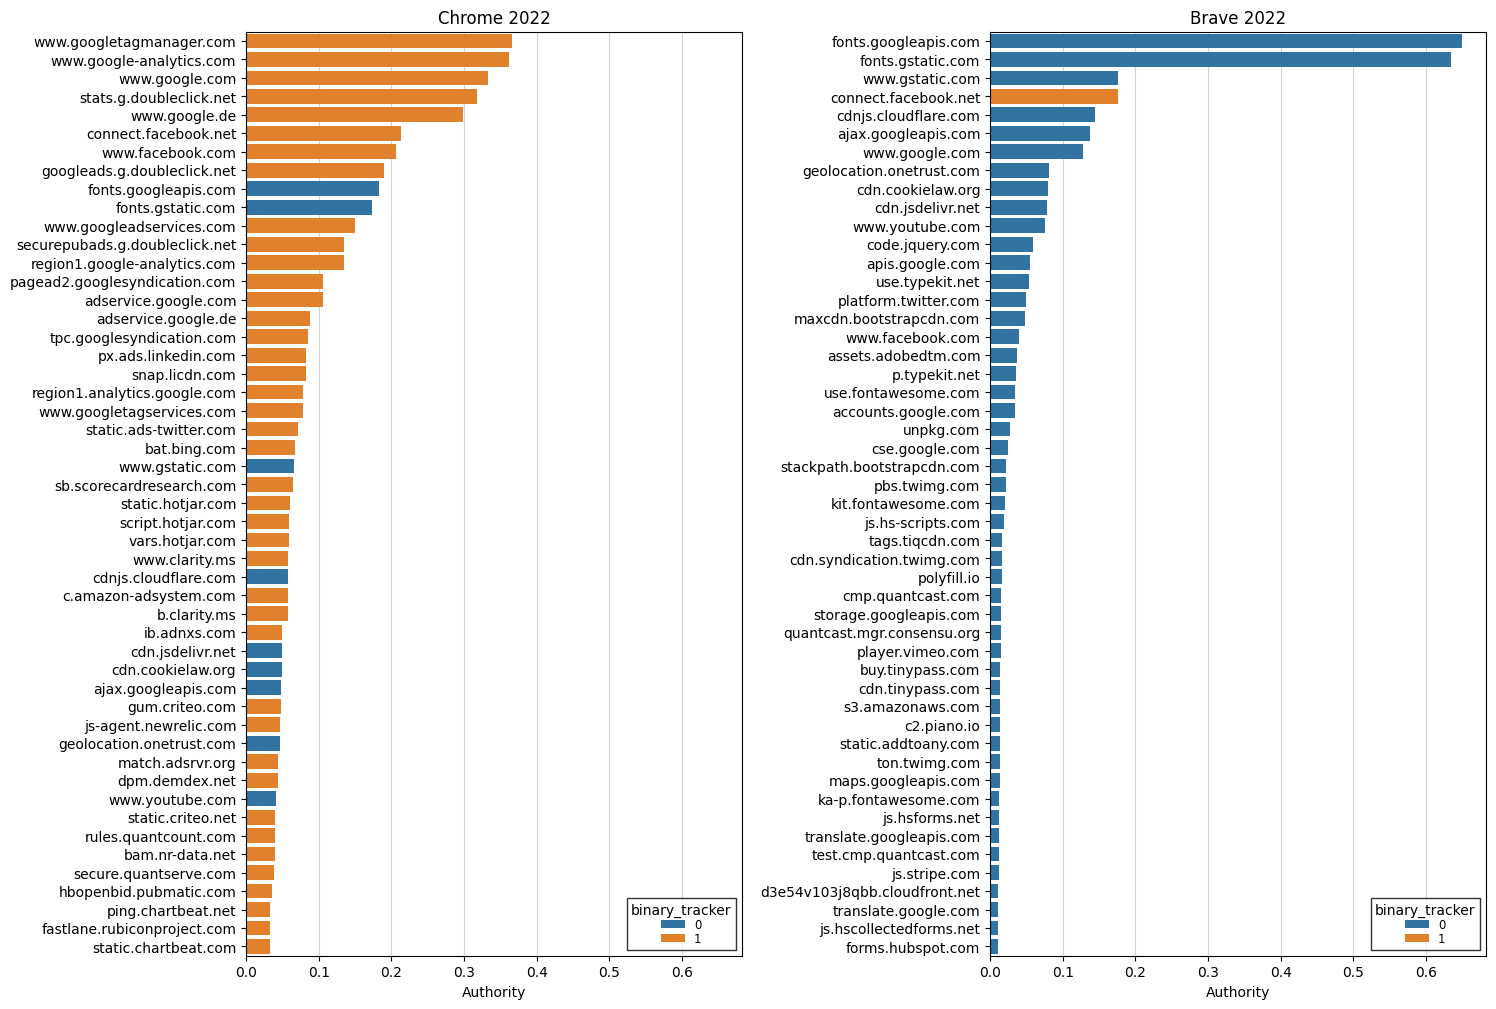

In [355]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.seterr(divide='ignore')

from export import mkdir_p
from os.path import join

_datasets = [ datasets[0] ] + [ datasets[2] ]

n = len(_datasets)
alpha = 4

col = 'authority'

fig, axes = plt.subplots(ncols=n, figsize=(2 * n * alpha, 1.5 * n * alpha), sharex=True)

for index, dataset in enumerate(_datasets):
  df = dataset['data'].sort_values(col, ascending=False).head(50)

  if n == 1:
    ax = axes
  else:
    ax = axes[index]

  sns.barplot(
    data=df, 
    y="id", 
    x=col,
    hue=config.binary_tracker,
    ax=ax,
    dodge=False
  ).set(
    title=dataset['label'],
    ylabel='',
    xlabel='Authority',
  )

  ax.set_axisbelow(True)
  ax.grid(color='lightgray', axis='x')
  ax.legend(loc='lower right', edgecolor='black', fancybox=False, labelspacing=0.1, fontsize='small', title=config.binary_tracker)

fig.subplots_adjust(wspace=0.5)

dir = join(root, config.results_dir)
mkdir_p(dir)
plt.savefig(join(dir, 'hosts-authority-chrome-v-brave.pdf'), dpi=300, bbox_inches='tight')

# Feature Selection

In [356]:
zero_columns = []
for dataset in datasets:
  cols = dataset['data'].columns[dataset['data'].eq(0).all()]
  zero_columns = list(set(zero_columns + list(cols)))

print (zero_columns)

['websocket', 'ping', 'delete', 'search', 'patch']


In [357]:
features = data.feature_vector(datasets[0].get('data'))

print ('Number of features: ' + str(len(features)))
print ('\nFeatures: ' + ', '.join(features))

Number of features: 52

Features: xmlhttprequest, image, font, script, stylesheet, sub_frame, other, main_frame, csp_report, object, media, get, post, options, head, put, count, firstpartydisclosed, cookiesset, thirdpartycookie, avgurllength, avgreqperneighbor, avgqpperreq, avgqpperneighbor, avgrhperrq, avgrhperneighbor, avgresphperrq, avgresphperneighbor, avgcookiefieldsperrq, avgcookiefieldsperneighbor, maxsubdomaindepth, avgpathlength, frameidgtzero, hostsld, sldlength, hosturllength, indegree, outdegree, degree, eccentricity, closnesscentrality, harmonicclosnesscentrality, betweenesscentrality, authority, hub, pageranks, componentnumber, strongcompnum, modularity_class, stat_inf_class, clustering, eigencentrality


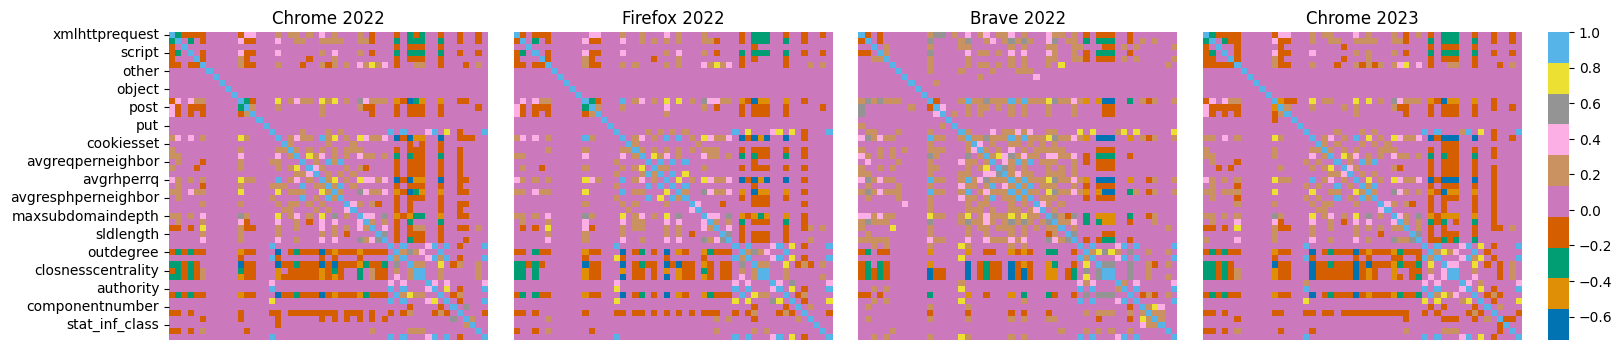

In [358]:
%matplotlib inline

n = len(datasets)
alpha = 4
cbar_width = 0.065

fig, axes = plt.subplots(
  ncols=n+1, 
  figsize=(n * alpha, alpha), 
  gridspec_kw={
    'width_ratios': [n - cbar_width] * n + [cbar_width * n] 
  }
)

for index, dataset in enumerate(datasets):
  corr = dataset['data'][features].corr()

  if len(datasets) == 1:
    ax = axes
  else:
    ax = axes[index]
  
  ax = sns.heatmap(
    corr,
    cmap=sns.color_palette('colorblind', as_cmap=True),
    ax=ax,
    cbar=True if index == len(datasets)-1 else False,
    cbar_ax=axes[len(datasets)] if index == len(datasets)-1 else None
  )
  ax.set(
    title=dataset['label'],
    xticks=[]
  )

  if index > 0:
    ax.set(yticks=[])

fig.subplots_adjust(hspace=0.125, wspace=0.1)    

dir = join(root, config.results_dir)
mkdir_p(dir)
plt.subplots_adjust(right=1)
plt.savefig(join(dir, 'dataset-correlations.pdf'), dpi=300)

# Evaluation

In [359]:
from sklearn.preprocessing import LabelEncoder

hosts = pd.concat([ x['data']['hostsld'] for x in datasets]).drop_duplicates().reset_index()
le = LabelEncoder()
le.fit(hosts['hostsld'])

for dataset in datasets:
  dataset['data']['hostsld'] = le.transform(dataset['data']['hostsld'])
    

In [360]:
targets = [ 
  config.binary_tracker
]

In [361]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = dict()
for target in targets:
  models[target] = list()

models[config.binary_tracker] = [
    RandomForestClassifier(n_estimators=100, n_jobs=-1),
    XGBClassifier(learning_rate=1, subsample=1, use_label_encoder=False, eval_metric='error'),
]  

In [367]:
compute_options = {
  'classifications': True,
  'feature_importances': False,
  'cross_validations': True,
  'misclassifications': True
}

In [368]:
%matplotlib agg

results = model.compute_results(
  datasets[:1],
  models, 
  features, 
  targets,
  root,
  compute_options,
  no_train=False,
  scaler=None
)

## Results

In [369]:
from IPython.display import display

output = export.pretty_results(root, datasets[:1])

for o in output:
  display(o)

,Chrome 2022,accuracy,precision,recall,f1_score
0,RandomForestClassifier,0.884,0.866,0.876,0.870
1,XGBClassifier,0.874,0.857,0.858,0.857


## Cross-browser and longitudinal performance

In [370]:
from joblib import load
from os.path import join

path = join('models', 'Chrome 2022')
chrome_2022_rf = load(join(path, 'RandomForestClassifier.sav'))
chrome_2022_xgb = load(join(path, 'XGBClassifier.sav'))
scaler = load(join(path, 'std_scaler.sav'))

models[config.binary_tracker] = [
  chrome_2022_rf,
  chrome_2022_xgb
]

results = model.compute_results(
  datasets[1:],
  models, 
  features,
  targets,
  root,
  compute_options,
  no_train=True,
  scaler=scaler
)

In [371]:
from IPython.display import display

output = export.pretty_results(root, datasets[1:])

for o in output:
  display(o)

,Firefox 2022,accuracy,precision,recall,f1_score
0,RandomForestClassifier,0.814,0.731,0.826,0.754
1,XGBClassifier,0.793,0.712,0.808,0.731


,Brave 2022,accuracy,precision,recall,f1_score
0,RandomForestClassifier,0.905,0.519,0.745,0.514
1,XGBClassifier,0.902,0.518,0.739,0.512


,Chrome 2023,accuracy,precision,recall,f1_score
0,RandomForestClassifier,0.887,0.864,0.885,0.873
1,XGBClassifier,0.873,0.849,0.862,0.855
